# Application of Deep Knockoffs for Functional Magnetic Resonance Imaging to Generate Surrogate Data

This notebook describes the pipeline to follow to build Knockoffs from fMRI images. These knockoffs generate surrogate data that is used in non-parametric tests to obtain a Statistical Parametric Map (SPM) of the brain.

First of all, some things to consider:
* fMRI images have been obtained from the Brain Connectome Project and previously preprocessed. 
* 

## Structure
The process is divided into 3 main parts, which consist of:
#### 1. Performing the **General Linear Model (GLM)** on the data
This is the classical method to obtain the SPM, which returns the fitted beta values for $$ y = X\beta$$ where y is the fMRI timecourse and X is the design matrix of the experiment.


#### 2. Generating Knockoffs
Given the data, the algorithm will build a machine to generate surrogate timecourses. 
There are three methods:
    * Gaussian Knockoffs
    * Low Rank Knockoffs
    * Deep Knockoffs
    
    
#### 3. Performing **Non-Parametric Tests**
The GLM is applied to the generated surrogate data to get the beta values and these are used to threshold the true betas using Non-Parametric Tests, which can be:
    * Uncorrected Non-Parametric Test
    * Corrected Non-Parametric Test
    



In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

from implementation import glm, knockoff_class, params
from implementation.load import load_pickle
from implementation.utils import KNOCK_DIR

## 1. GLM

In [6]:
glm.run()

 MOTOR 
Loading data for task MOTOR...
Loaded Data - Shape: (100, 379, 284)
Loaded Task Paradigms - Shape: (100, 284)
Computing GLM for task MOTOR...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task MOTOR...
 GAMBLING 
Loading data for task GAMBLING...
Loaded Data - Shape: (100, 379, 253)
Loaded Task Paradigms - Shape: (100, 253)
Computing GLM for task GAMBLING...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task GAMBLING...
 RELATIONAL 
Loading data for task RELATIONAL...
Loaded Data - Shape: (100, 379, 232)
Loaded Task Paradigms - Shape: (100, 232)
Computing GLM for task RELATIONAL...
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 100 subjects and 379 regions...
Done!
Saving activations and beta values for task RELATIONAL...
 SOCIAL 
Loading data for task SOCIAL...
Loa

## 2. Building Knockoffs

In [7]:
task = 'MOTOR'
subject = 1

### a) Gaussian Knockoffs

Loaded Data - Shape: (100, 379, 284)
Divided 379 variables into 154 groups.
Divided 379 variables into 154 groups.
Size of largest groups: 37
Mean groups size: 2.461038961038961
Eigenvalue for Sigma Hat, Min: -2.254258744564657e-15
Eigenvalue for Sigma Hat Representatives, Min: 0.0436073458894031
Original for Correlations, Max: 0.8022580778679829
Representatives for Correlations, Max: 0.4585931438028127
Average absolute pairwise correlation: 0.859.


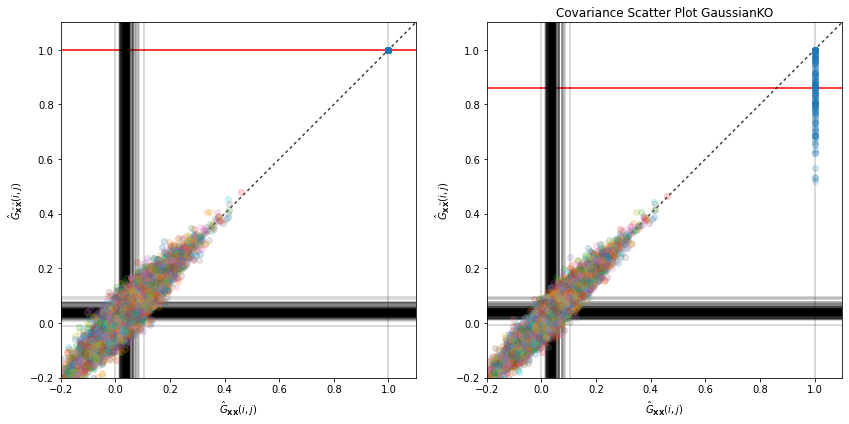

                               Value                                     \
                               count        mean        std         min   
Method     Metric     Swap                                                
GaussianKO Covariance full     100.0  233.369678  12.635559  205.836100   
                      partial  100.0  259.049058  12.547003  235.147311   
                      self     100.0    0.858640   0.000964    0.856491   
           Energy     full     100.0    0.308141   0.005584    0.296243   
                      partial  100.0    0.309154   0.005726    0.297983   
           KNN        full     100.0    0.644120   0.022952    0.577465   
                      partial  100.0    0.657817   0.021615    0.591549   
           MMD        full     100.0   -0.001885   0.000325   -0.002577   
                      partial  100.0   -0.001781   0.000323   -0.002430   

                                                                               
                   

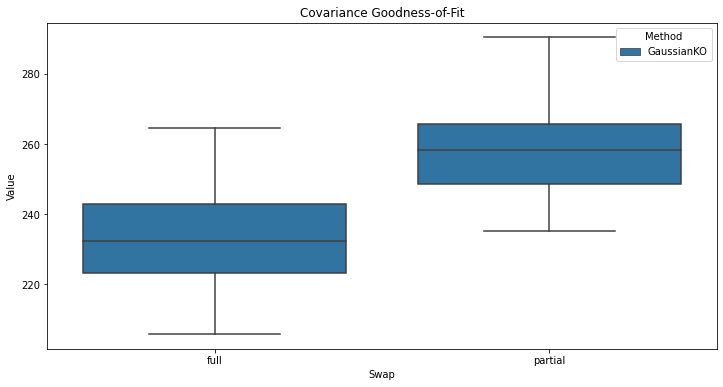

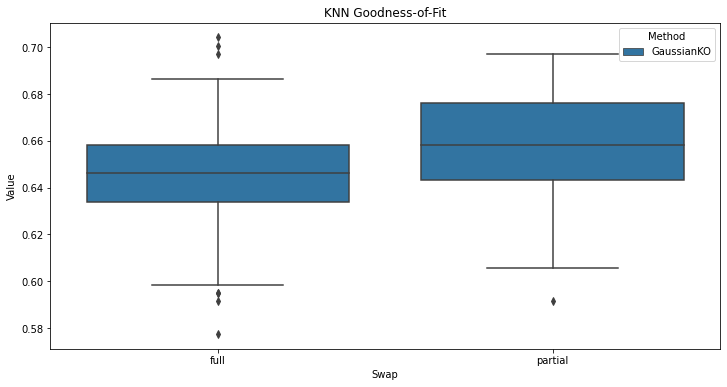

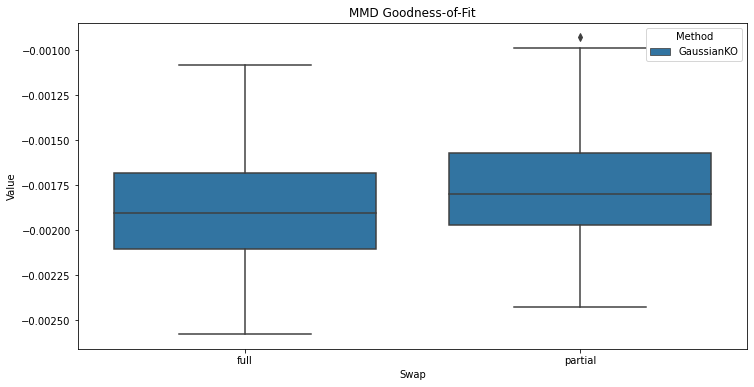

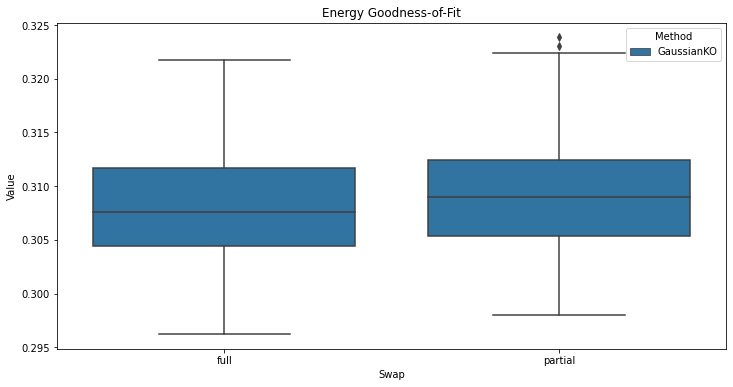

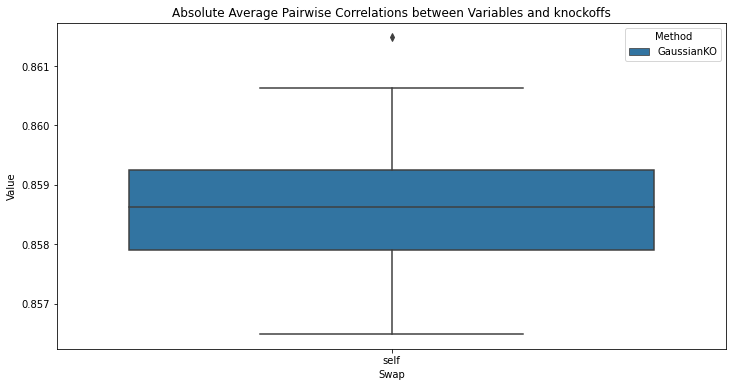

In [8]:
gaussian = knockoff_class.GaussianKnockOff(task, subject)  

gaussian.load_fmri()

# Pre-processing the data: clustering to avoid correlations
gaussian.pre_process(max_corr=.3)

# Training the machine to build second-order knockoffs
_ = gaussian.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_gaus = gaussian.diagnostics()

In [9]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_gaussian = gaussian.transform()
print(data_gaussian.shape)

(101, 284, 379)


### b) Low Rank Knockoffs

Loaded Data - Shape: (100, 379, 284)


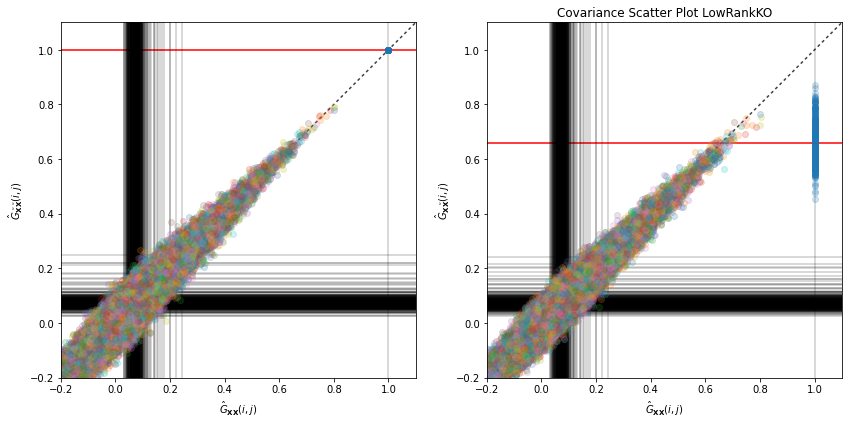

                              Value                                        \
                              count         mean         std          min   
Method    Metric     Swap                                                   
LowRankKO Covariance full     100.0  4226.335985  171.986711  3801.085378   
                     partial  100.0  4754.557508  172.758649  4312.221056   
                     self     100.0     0.656399    0.001228     0.652706   
          Energy     full     100.0     0.578941    0.012548     0.546045   
                     partial  100.0     0.584502    0.012661     0.554272   
          KNN        full     100.0     0.855739    0.015502     0.809859   
                     partial  100.0     0.881444    0.014973     0.848592   
          MMD        full     100.0     0.002730    0.000466     0.001477   
                     partial  100.0     0.003125    0.000463     0.001979   

                                                                     \
    

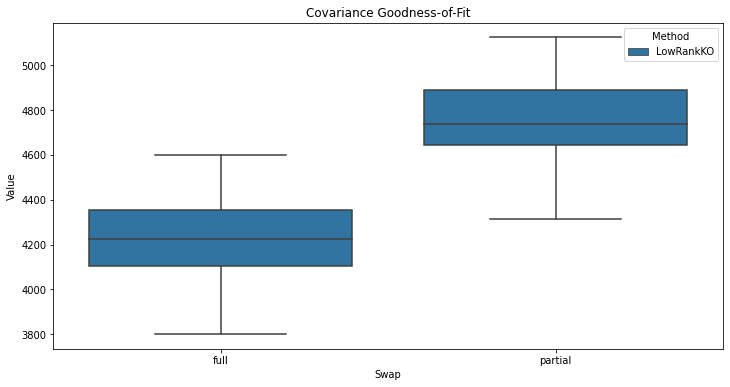

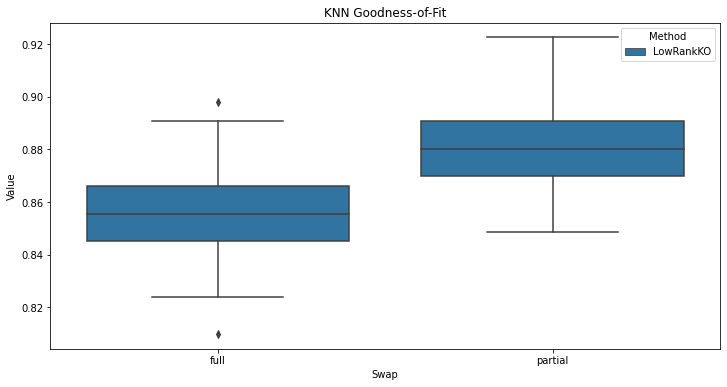

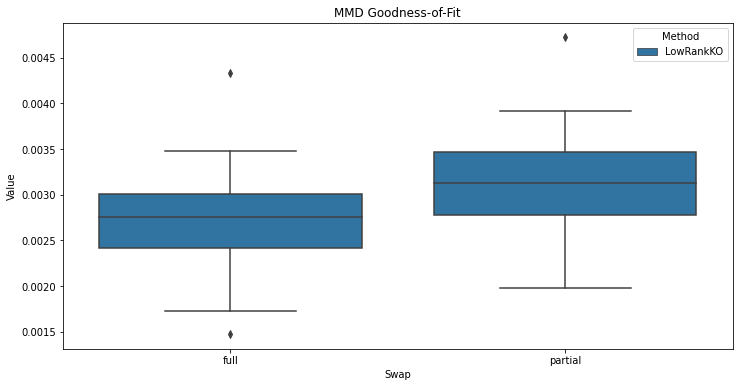

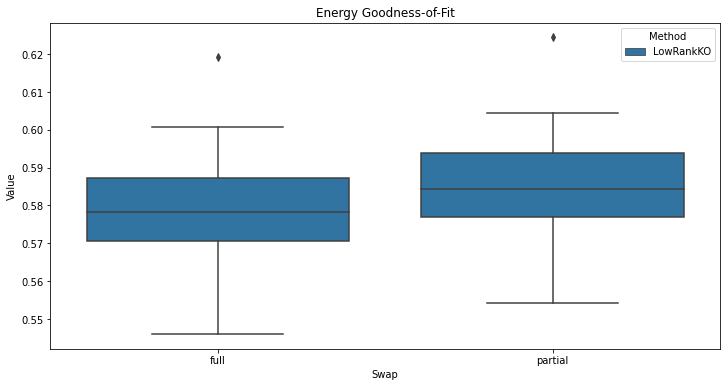

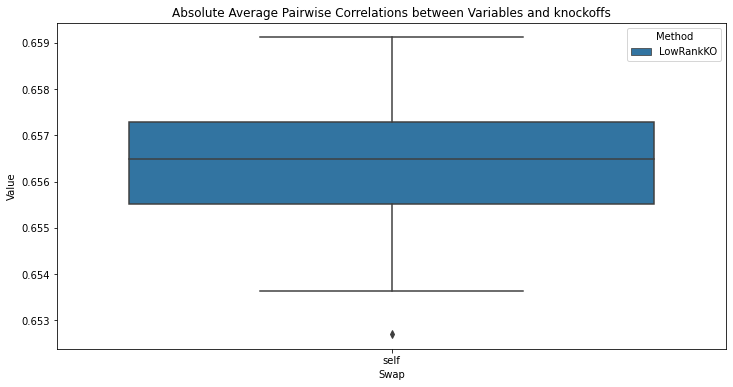

In [10]:
lowrank = knockoff_class.LowRankKnockOff(task, subject)  

lowrank.load_fmri()

# Training the machine to build low-ranked knockoffs
_ = lowrank.fit(rank=120) 

# Plotting diagnostics to show the performance of the knockoffs
res_lowrank = lowrank.diagnostics()

In [11]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
data_lowrank = lowrank.transform()
print(data_lowrank.shape)

(101, 284, 379)


### c) Deep Knockoffs

Loaded Data - Shape: (100, 379, 405)
Divided 379 variables into 172 groups.
Divided 379 variables into 172 groups.
Size of largest groups: 73
Mean groups size: 2.203488372093023
Eigenvalue for Sigma Hat, Min: 9.720730766844742e-05
Eigenvalue for Sigma Hat Representatives, Min: 0.0938594830687364
Original for Correlations, Max: 0.8400040776752848
Representatives for Correlations, Max: 0.4169587905093779
Saving file GaussianKO_tfMRI_tWM_s0_c0.3.pickle
Saving file GaussianKO_mapping_tWM_s0_c0.3.pickle
Average absolute pairwise correlation: 0.731.
Saving file DeepKO_tWM_s0_params
=> no checkpoint found at '/home/alex/Documents/epfl/machine_learning/machine-learning-cs433-p2/data/output/knockoffs/DeepKO_tWM_s0_checkpoint.pth.tar'


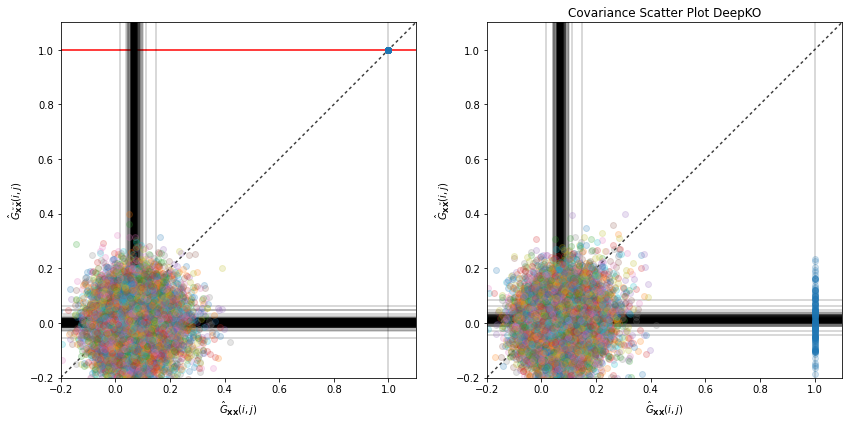

                           Value                                        \
                           count        mean           std         min   
Method Metric     Swap                                                   
DeepKO Covariance full     100.0  850.569505  8.646960e-05  850.569229   
                  partial  100.0  572.610034  2.769260e+01  511.440045   
                  self     100.0    0.065099  2.596457e-03    0.059032   
       Energy     full     100.0    0.225535  1.249516e-05    0.225505   
                  partial  100.0    0.236621  3.870439e-03    0.229219   
       KNN        full     100.0    1.000000  0.000000e+00    1.000000   
                  partial  100.0    0.949678  1.776953e-02    0.883663   
       MMD        full     100.0    0.008161  9.559268e-07    0.008159   
                  partial  100.0    0.007086  2.889255e-04    0.006443   

                                                                           
                                  2

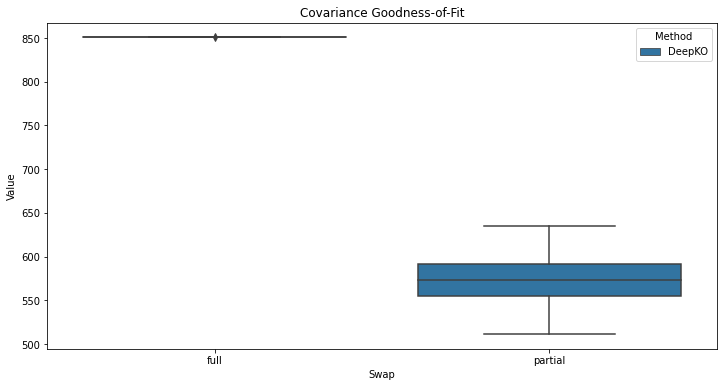

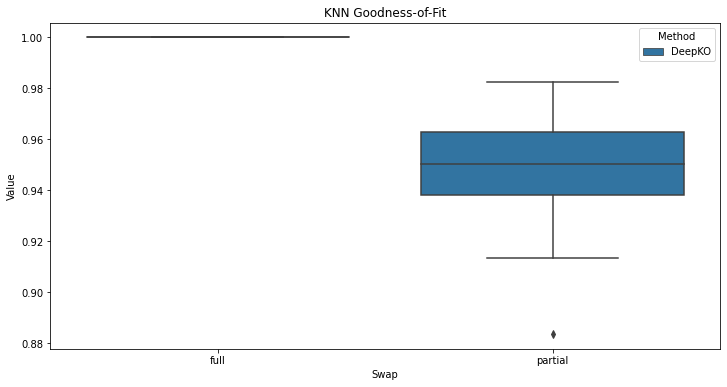

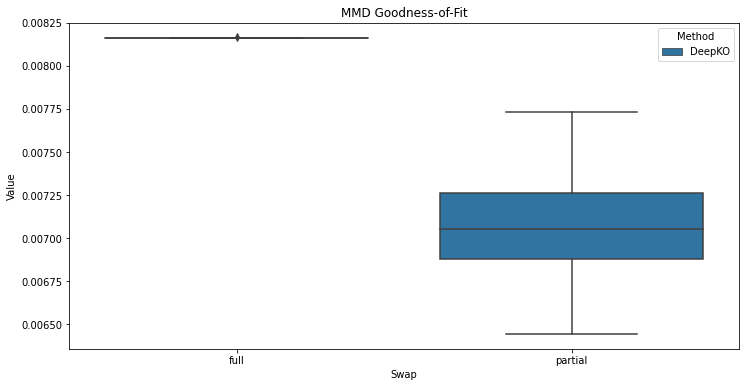

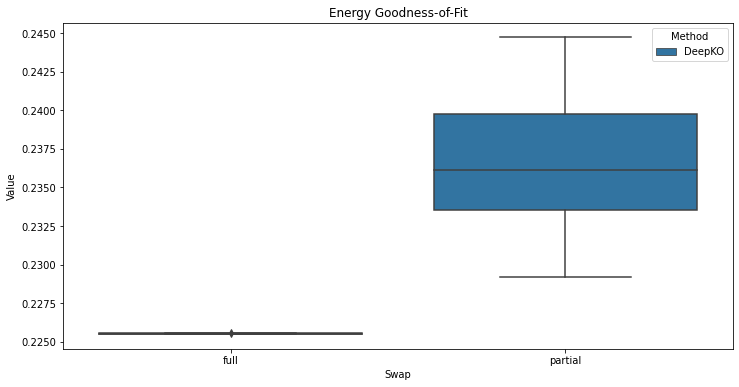

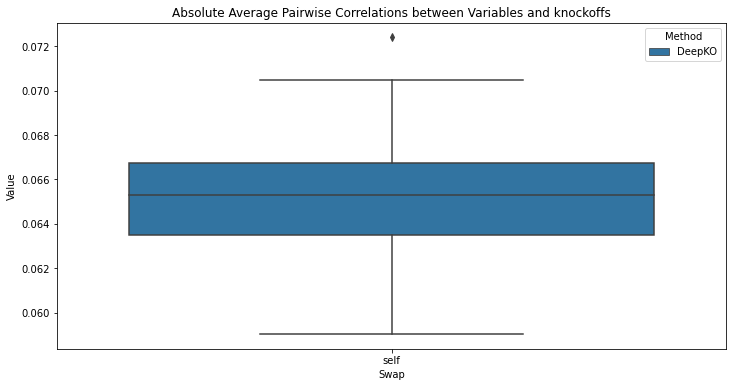

In [12]:
# We can load a previously trained machine


deepko_wm = knockoff_class.DeepKnockOff('WM', 0)
deepko_wm.pre_process(max_corr=.3, save=True)

# Loading previously trained machine
_, x_train = load_pickle(KNOCK_DIR, 'GaussianKO_tfMRI_tWM_s0_c0.3.pickle')
groups, _ = load_pickle(KNOCK_DIR, 'GaussianKO_mapping_tWM_s0_c0.3.pickle')
#params = load_pickle(KNOCK_DIR, 'DeepKO_params_DeepKO_tMOTOR_s10')

deepko_wm.load_x(x_train)
#deepko.load_params(params)
deepko_wm.load_machine()

res_deepko_wm = deepko_wm.diagnostics()

In [ ]:
# Or train a new knockoff machine

deepko = knockoff_class.DeepKnockOff(task, subject)  

# Pre-processing the data: clustering to avoid correlations
deepko.pre_process(max_corr=.3, save=True)

# Training the machine to build second-order knockoffs. The parameters can be changed at params.py
_ = deepko.fit() 

# Plotting diagnostics to show the performance of the knockoffs
res_deepko = deepko.diagnostics()

In [13]:
data_deepko_wm = deepko_wm.transform(groups=groups)

deepko_wm_betas = deepko_wm.statistic(data_deepko_wm, save=True)
uncorrected_betas_deepko_wm, corrected_betas_deepko_wm = deepko_wm.threshold(deepko_wm_betas, save=True)


Loaded Task Paradigms - Shape: (100, 405)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tWM_s0.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tWM_s0.mat
Saving file DeepKO_corrected_betas_tWM_s0.mat


In [14]:
# Building the knockoffs: the resulting data matrix will be of shape (real+knockoff, timepoints, regions),
# with (0,:,:) containing the real beta value and (1:, :, :) containing the knockoffs
deepko_wm.transform()
print(data_deepko_wm.shape)

(101, 405, 379)


## Comparing the knockoff diagnostics

In [17]:
from implementation.utils import do_plot

def compare_diagnostics(results):
    """
    Plots the diagnostics for all `Methods` in the results data frame. Allows for direct 
    comparison between knockoff generators.
    """
    # init
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
    matplotlib.rcParams.update(params)
    fig, axs = plt.subplots(nrows=2, ncols=3)
    axs = axs.flatten()
    # plotting offdiagonal Covariance diagnostics
    do_plot(results, 'Covariance', False, axs[0])
    axs[0].set_title('Offdiagonal Covariance Goodness-of-Fit')
    axs[0].get_legend().remove()
    # plotting KNN diagnostics
    do_plot(results, 'KNN', False, axs[1])
    axs[1].set_title('KNN Goodness-of-Fit')
    axs[1].get_legend().remove()
    # plotting MMD diagnostics
    do_plot(results, 'MMD', False, axs[2])
    axs[2].set_title('MMD Goodness-of-Fit')
    axs[2].get_legend().remove()
    # plotting Energy diagnostics
    do_plot(results, 'Energy', False, axs[3])
    axs[3].set_title('Energy Goodness-of-Fit')
    axs[3].get_legend().remove()
    # plotting diagonal Covariance diagnotics
    do_plot(results, 'Covariance', True, axs[4])
    axs[4].set_title('Diagonal Covariance Goodness-of-Fit')
    axs[4].get_legend().remove()
    # axs[4].tick_params(**params)
    fig.delaxes(ax=axs[5])
    fig.tight_layout()
    handles, labels = axs[4].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', fontsize='xx-large', bbox_to_anchor=(0.9, 0.2))
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    

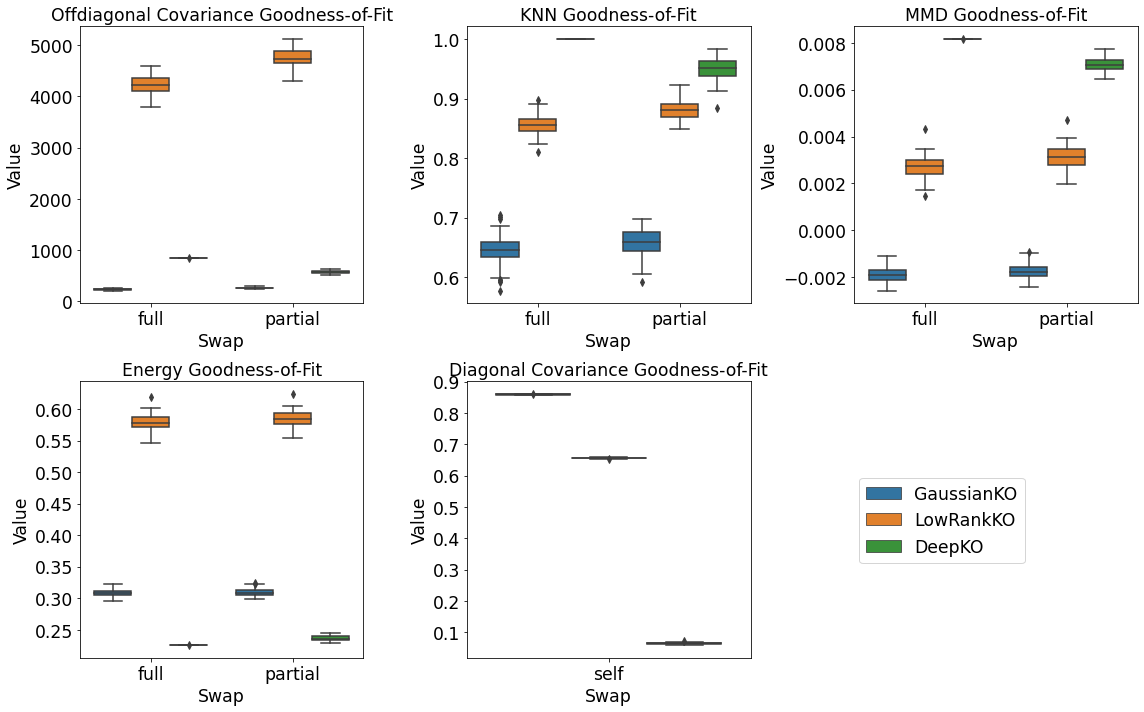

In [18]:
import pandas as pd

res_total = pd.concat([res_gaus, res_lowrank, res_deepko_wm], ignore_index=True, sort=False)

compare_diagnostics(res_total)

## 3. Non-Parametric tests

In [12]:
# Computing the beta values of the knockoffs
gaussian_betas = gaussian.statistic(data_gaussian, save=True)
lowrank_betas = lowrank.statistic(data_lowrank, save=True)
deepko_betas = deepko.statistic(data_deepko, save=True)


Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file GaussianKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file LowRankKO_KObetas_tMOTOR_s1.mat
Loaded Task Paradigms - Shape: (100, 284)
Separating conditions...
Done!
Convolving...
Done!
Fitting GLM for 101 subjects and 379 regions...
Done!
Saving file DeepKO_KObetas_tMOTOR_s1.mat


In [13]:
# Performing corrected and uncorrected Non-Parametric tests to threshold
uncorrected_betas_gaussian, corrected_betas_gaussian = gaussian.threshold(gaussian_betas, save=True)
uncorrected_betas_lowrank, corrected_betas_lowrank = lowrank.threshold(lowrank_betas, save=True)
uncorrected_betas_deepko, corrected_betas_deepko = deepko.threshold(deepko_betas, save=True)

Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file GaussianKO_uncorrected_betas_tMOTOR_s1.mat
Saving file GaussianKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file LowRankKO_uncorrected_betas_tMOTOR_s1.mat
Saving file LowRankKO_corrected_betas_tMOTOR_s1.mat
Performing uncorrected non-parametric test...
Performing corrected non-parametric test...
Saving file DeepKO_uncorrected_betas_tMOTOR_s1.mat
Saving file DeepKO_corrected_betas_tMOTOR_s1.mat
